In [1]:
import pyccl as ccl
print(f"I am using pyccl version {ccl.__version__}")
import numpy as np
from scripts.data_vectors import Metrics
import scripts.plotting as plot

I am using pyccl version 2.8.0


In [9]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)
redshift_range_1 = np.linspace(0, 3.5, 300)
redshift_range_2 = np.linspace(0, 3.5, 5000)
ells_1 = np.geomspace(20, 2000, 50)
ells_2 = np.geomspace(20, 5000, 50)

mtx_1 = Metrics(cosmo, redshift_range_1, ells_1, perform_binning=True)
mtx_2 = Metrics(cosmo, redshift_range_2, ells_1, perform_binning=True)

shear_1 = mtx_1.cosmic_shear_cls()
shear_2 = mtx_2.cosmic_shear_cls()

clu_1 = mtx_1.galaxy_clustering_cls()
clu_2 = mtx_2.galaxy_clustering_cls()


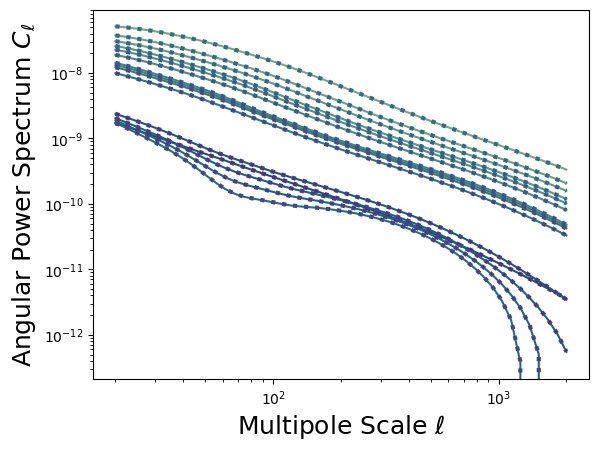

In [10]:
plot.compare_two_data_vector_sets_absolute(shear_1, shear_2, ells_1, ells_1)

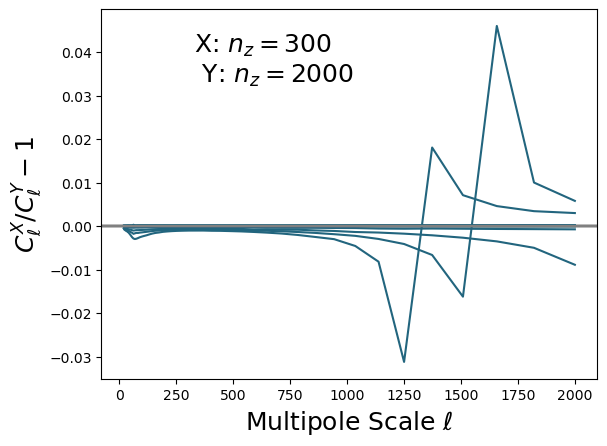

In [11]:
plot.compare_two_data_vector_sets_relative(shear_1,
                                           shear_2,
                                           ells_1,
                                           ells_1,
                                           label_1="$n_z=300$", 
                                           label_2="$n_z=2000$")

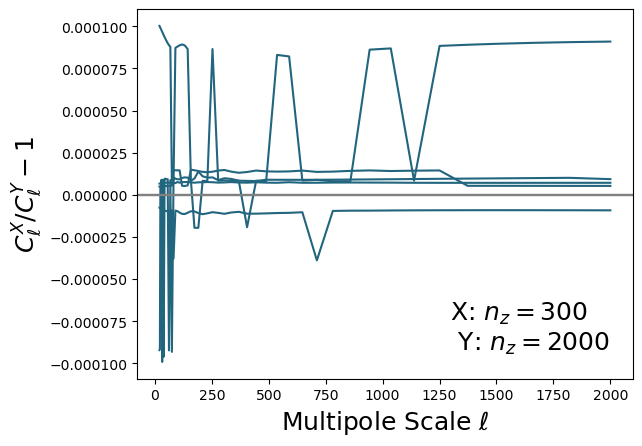

In [8]:
plot.compare_two_data_vector_sets_relative(clu_1,
                                           clu_2,
                                           ells_1,
                                           ells_1,
                                           label_1="$n_z=300$", 
                                           label_2="$n_z=2000$")